In [1]:
import keras
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Flatten

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold, cross_val_score

from mlxtend.plotting import plot_decision_regions
base_path = "./"
file_path = base_path + "heart.csv"
data = pd.read_csv(file_path)

X_data = data.iloc[:, :-1]
# print(X_data.shape)
Y_data = data.iloc[:, -1]

Using TensorFlow backend.


In [2]:
def get_data():
    base_path = "./"
    file_path = base_path + "heart.csv"
    data = pd.read_csv(file_path)

    X_data = data.iloc[:, :-1]
    # print(X_data.shape)
    Y_data = data.iloc[:, -1]
    
    scaler = MinMaxScaler()
    X_scaled_data = scaler.fit_transform(X_data)
    X_data = X_scaled_data
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, shuffle=True)

    return X_train, X_test, Y_train, Y_test, X_data, Y_data

# get_data()

def get_dummies(scaler_type):
    base_path = "./"
    file_path = base_path + "heart.csv"
    data = pd.read_csv(file_path)

    X_data = data.iloc[:, :-1]
    # print(X_data.shape)
    Y_data = data.iloc[:, -1]
    
    feature_names = X_data.columns.tolist()
    
    if (scaler_type == "Standard"):

        # Convert categorical variable into dummy/indicator variables.
        X_data = pd.get_dummies(X_data, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])

        # standardscaler removes the mean
        # and scales the data to unit variance.
        # unit varience = determines the standard deviation of the signal
        # and devide all entries by that value.
        # it means -> its distribution will have a mean value 0
        # and standard deviation of 1.

        scaler = StandardScaler()
        columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
        X_data[columns_to_scale] = scaler.fit_transform(X_data[columns_to_scale])

    elif (scaler_type == "MinMax"):
        columns_to_scale = [0, 3, 4, 7, 9]

        for c in columns_to_scale:

            X_data.iloc[:,c] -= X_data.iloc[:,c].min()
            diff = X_data.iloc[:,c].max() - X_data.iloc[:,c].min()
            X_data.iloc[:,c] /= diff

            column = X_data.iloc[:,c]

            for i in range(len(column)):
                val = column[i]

                if (val >= 0.0 and val < 0.2):
                    X_data.iloc[i,c] = 0
                elif (val >= 0.2 and val < 0.4):
                    X_data.iloc[i,c] = 1
                elif (val >= 0.4 and val < 0.6):
                    X_data.iloc[i,c] = 2
                elif (val >= 0.6 and val < 0.8):
                    X_data.iloc[i,c] = 3
                else:
                    X_data.iloc[i,c] = 4
        X_data.to_csv(path_or_buf="debug.csv", decimal=',', index=False)
        # X_data = pd.get_dummies(X_data, columns=feature_names)
            
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, shuffle=True)

    return X_train, X_test, Y_train, Y_test, X_data, Y_data

def get_data_post_feature_selection():
    selected_features = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
    
    selected_features.sort()
    
    X_data = data.iloc[:, selected_features]
    Y_data = data.iloc[:, -1]
    
    scaler = MinMaxScaler()
    X_scaled_data = scaler.fit_transform(X_data)
    X_data = X_scaled_data
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, shuffle=True)

    return X_train, X_test, Y_train, Y_test, X_data, Y_data

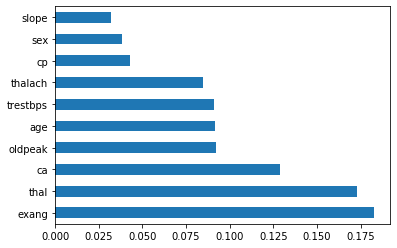

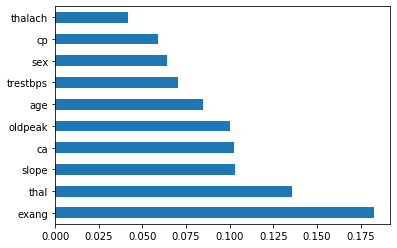

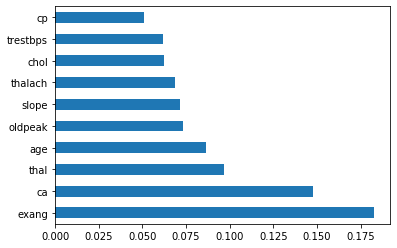

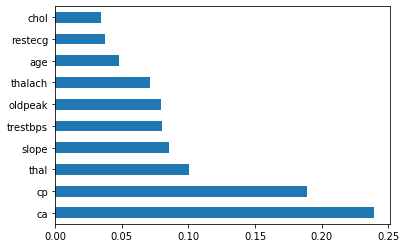

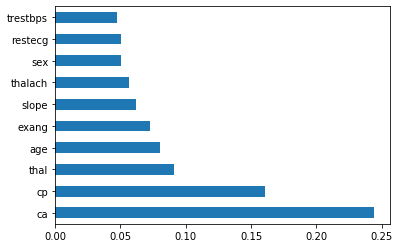

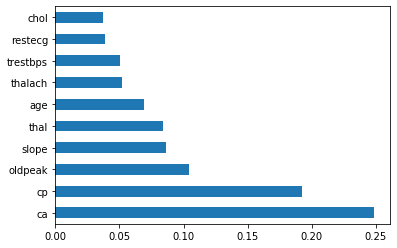

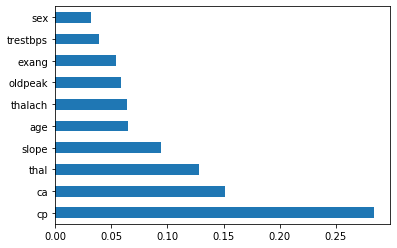

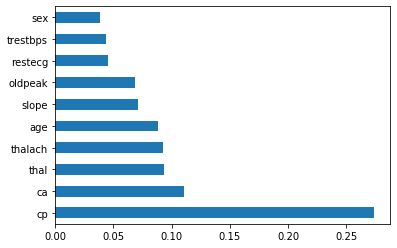

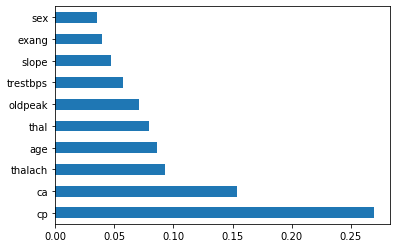

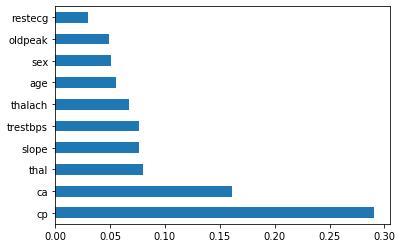

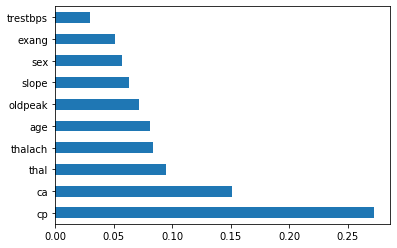

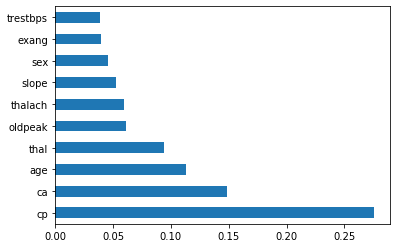

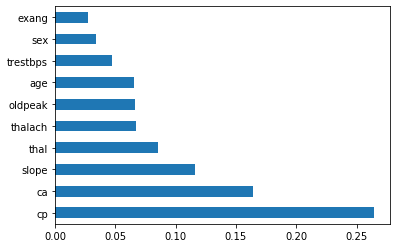

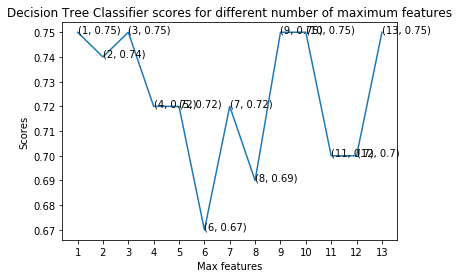

0.7540983606557377


InvocationException: GraphViz's executables not found

In [3]:
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from sklearn import tree
import pydotplus

def decision_tree():
    X_train, X_test, Y_train, Y_test, X_data, Y_data = get_dummies("MinMax")
    # feature_names = X_data.columns.tolist()
    # print(feature_name)

    # scores = {}
    scores = []
    features = len(X_data.columns)

    for i in range(1, features+1):

        decision_tree = DecisionTreeClassifier(criterion="gini", max_features=i, random_state=0)
        # The number of features to consider when looking for the best split

        decision_tree.fit(X_train, Y_train)
        Y_pred = decision_tree.predict(X_test)
        score = decision_tree.score(X_test, Y_test)
        score = round(score, 2)
        scores.append(score)
        # print(decision_tree.feature_importances_)
        feat_importances = pd.Series(decision_tree.feature_importances_, index=X_data.columns)
        feat_importances.nlargest(10).plot(kind='barh')
        plt.show()

    plt.plot([i for i in range(1, features+1)], scores)

    for i in range(1, features+1):
        plt.text(i, scores[i-1], (i, scores[i-1]))

    plt.xticks([i for i in range(1, features+1)])
    plt.xlabel('Max features')
    plt.ylabel('Scores')
    plt.title('Decision Tree Classifier scores for different number of maximum features')
    plt.show()

    decision_tree_best_features = DecisionTreeClassifier(criterion="gini", max_features=10, random_state=0)
    decision_tree_best_features.fit(X_train, Y_train)
    score = decision_tree_best_features.score(X_test, Y_test)
    print(score)

    dot_data = tree.export_graphviz(decision_tree_best_features, out_file=None, 
                                    # feature_names=names, 
                                    rounded=True,
                                    filled=True)

    # Draw graph
    graph = pydotplus.graph_from_dot_data(dot_data)  

    # Show graph
    Image(graph.create_png())

decision_tree()

In [ ]:
def univariate_selection():
    
    bestfeatures = SelectKBest(score_func=chi2, k=10)
    # SelectKBest = Select features according to the k highest scores.
    # chi2 = Compute chi-squared stats between each non-negative feature and class.
             
            # = the chi-squared test is used to determine 
            # whether there is a significant difference 
            # between the expected frequencies and the observed frequencies 
            # in one or more categories.
    fit =  bestfeatures.fit(X_data, Y_data)
    scores = pd.DataFrame(fit.scores_)
    columns = pd.DataFrame(X_data.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([columns, scores],axis=1)
    featureScores.columns = ['Feature','Score']  #naming the dataframe columns
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    
    # thalach = maximum heart rate achieved
    
univariate_selection()

[0.07302296 0.05483362 0.12704046 0.06450796 0.05406784 0.0219202
 0.04012419 0.07504622 0.08851468 0.07757233 0.0816155  0.13798893
 0.1037451 ]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


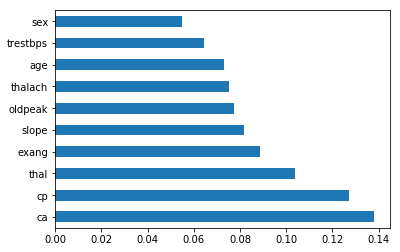

In [10]:
def feature_importance():
    
    extra_tree = ExtraTreesClassifier()
    # This class implements a meta estimator that 
    # fits a number of randomized decision trees (a.k.a. extra-trees)
    # on various sub-samples of the dataset 
    # and uses averaging to improve the predictive accuracy 
    # and control over-fitting.
    
    extra_tree.fit(X_data,Y_data)
    print(extra_tree.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(extra_tree.feature_importances_, index=X_data.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()
    
feature_importance()

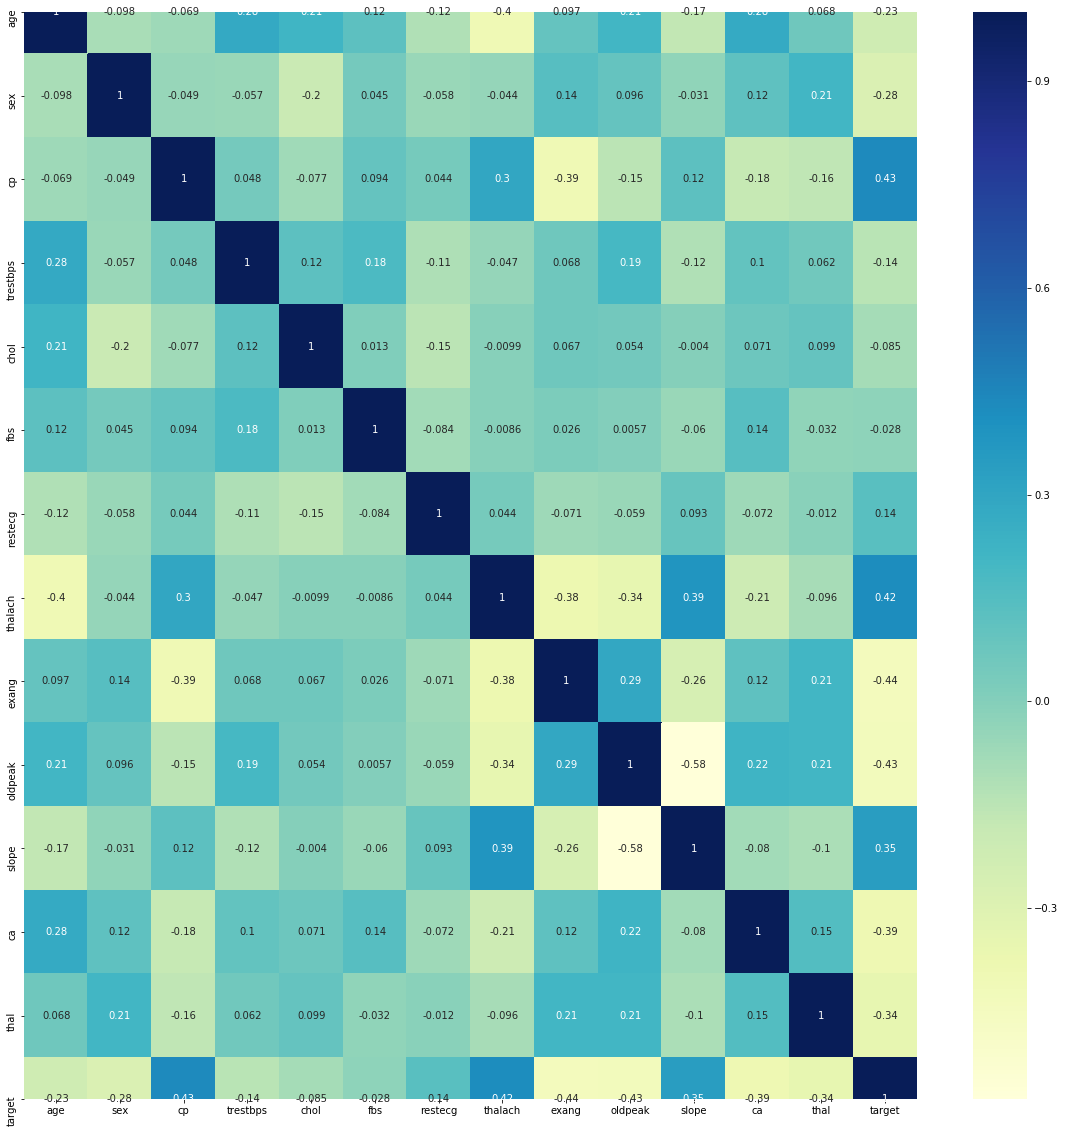

In [5]:
def heat_map():
    
    corrmat = data.corr()
    # data.corr() finds the pairwise correlation of all columns 
    
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    graph = sns.heatmap( data[top_corr_features].corr(), annot=True, cmap="YlGnBu")

heat_map()

In [6]:
def feature_selection():
    
    base_path = "/Users/heejoojin/Projects/ML/CS4641/"
    file_path = base_path + "heart.csv"
    data = pd.read_csv(file_path)
    num_channels = data.shape[1] - 1
    
    # print(data)
    
    channel_list = list(np.arange(0, num_channels))
    chosen_features = []
    
    for i, column in enumerate(data.columns):
        
        if (column != "target"):
            print("Finding feature #" + str(i) + ': ')
            channel_scores = {}
            
            for channel in channel_list:
                
                testing_features = chosen_features + [channel]
                feature_list = testing_features
                
                X_data = data.iloc[:, feature_list]
                Y_data = data.iloc[:, -1]
                
                scaler = MinMaxScaler()
                X_scaled_data = scaler.fit_transform(X_data)
                X_data = X_scaled_data

                X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, shuffle=True)

                model = Sequential()
                model.add(Dense(60, activation='linear', input_shape=(X_train.shape[1],)))
                model.add(Dense(1, activation='sigmoid'))
                checkpoint_filepath = base_path + "checkpoint.hdf5"
                early_stopping_callback = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0)
                checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=0, save_best_only=True,
                                        save_weights_only=True, mode='auto', period=1)
                callbacks_list = [checkpoint, early_stopping_callback]

                # Compile model
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae'])
                history = model.fit(X_train, Y_train, epochs=300, batch_size=32, validation_split=0.2, shuffle=True, verbose=0)

                # Y_pred = model.predict(np.array(X_test))
                scores = model.evaluate(X_test, Y_test, batch_size=32)
                
            channel_scores[channel] = scores[1]

        #find max score
        highest_channel = min(channel_scores, key=channel_scores.get)
        print(str(highest_channel) + "\t" + str(channel_scores[highest_channel]))
        #append channel to list
        chosen_features.append(highest_channel)
        print(chosen_features)
        if i != len(data.columns - 1):
            channel_list.remove(highest_channel)
            
        save_path = base_path + "feature_selection.csv"
        with open(save_path, 'a') as f:
            for item in chosen_features:
                f.write(str(item) + ", ")
            f.write("\t" + str(channel_scores[highest_channel]) + "\n\r")
        f.close()
# feature_selection()
    

61/61 [==============================] - 0s 39us/step
0.40131151236471585
0.8032786846160889


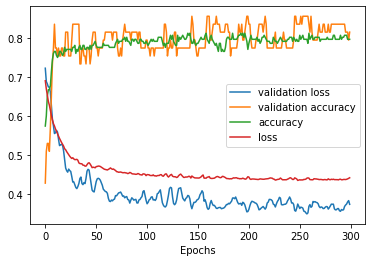

In [7]:
def nn_model():
    X_train, X_test, Y_train, Y_test, X_data, Y_data = get_data_post_feature_selection()
    
    model = Sequential()
    model.add(Dense(60, activation='linear', input_shape=(X_train.shape[1],)))
    model.add(Dense(1, activation='sigmoid'))
    
    checkpoint_filepath = base_path + "checkpoint.hdf5"
    
    early_stopping_callback = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0)
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=0, save_best_only=True,
                            save_weights_only=True, mode='auto', period=1)
    # checkpoint = save the model after every epoch.
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001, verbos=0)
    
    callbacks_list = [checkpoint, early_stopping_callback]

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    history = model.fit(X_train, Y_train, epochs=300, batch_size=32, validation_split=0.2, shuffle=True, verbose=0)
    
    # Y_pred = model.predict(np.array(X_test))
    test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=32)
    print(test_loss)
    print(test_acc)

    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    loss = history.history['loss']
    plt.plot(val_loss, label='validation loss')
    plt.plot(val_acc, label='validation accuracy')
    plt.plot(acc, label='accuracy')
    plt.plot(loss, label='loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
    # model.load_weights(checkpoint_filepath)
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
nn_model()
    

0.8524590163934426


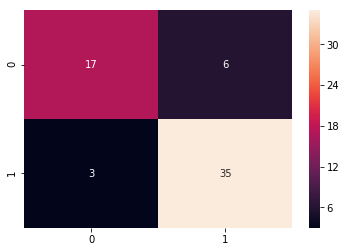

In [12]:
def SVM():
    X_train, X_test, Y_train, Y_test, X_data, Y_data = get_data()
    
    svm_model_linear = LinearSVC(random_state=0, tol=1e-5)
    # tol : float, optional (default=1e-4) = Tolerance for stopping criteria.
    model = svm_model_linear.fit(X_train, Y_train.values.flatten())
    
    Y_pred = svm_model_linear.predict(X_test)
    scores = cross_val_score(svm_model_linear, X_train, Y_train, cv=10)
    accuracy = accuracy_score(Y_test, Y_pred)
    cm = confusion_matrix(Y_test, Y_pred)
    sns.heatmap(cm, annot=True)
    
    print(accuracy)
    
SVM()
